## RAG APP p1 https://python.langchain.com/docs/tutorials/rag/

In [1]:
%pip install -qU langchain-ollama ollama langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Import and load environment variables
from dotenv import load_dotenv
import os
import getpass

#Python library used to display progress bars for loops
from tqdm.auto import tqdm
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
load_dotenv()

True

In [3]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model = "llama3.2-vision",
    temperature = 0,
    # num_predict = 256,
    # other params ...
)

from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llama3.2-vision")

In [4]:
pip install -qU langchain-chroma

Note: you may need to restart the kernel to use updated packages.


## create the DB

In [5]:
from langchain_chroma import Chroma
#in memory
vector_store = Chroma(embedding_function=embeddings)

# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk
# persist_directory = 'db'

# ## here we are using Ollama embeddings but in future we will swap out to local embeddings
# # embedding = OpenAIEmbeddings()
# embedding = OllamaEmbeddings(
#     model="llama3.2-vision"
# )

# vector_store = Chroma.from_documents(documents=texts, 
#                                  embedding=embedding,
#                                  persist_directory=persist_directory)


In [6]:
# persiste the db to disk
# vector_store.persist()
# vector_store = None

In [7]:
# Now we can load the persisted database from disk, and use it as normal. 
# vector_store = Chroma(persist_directory=persist_directory, 
#                   embedding_function=embedding)

## Preview
In this guide we’ll build an app that answers questions about the website's content. The specific website we will use is the LLM Powered Autonomous Agents blog post by Lilian Weng, which allows us to ask questions about the contents of the post.

We can create a simple indexing pipeline and RAG chain to do this in ~50 lines of code.

In [8]:
import bs4
# from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# prompt = hub.pull("rlm/rag-prompt:latest")

prompt = ChatPromptTemplate.from_messages([
  ("human", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question}\nContext: {context}\nAnswer:"),
])


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition refers to breaking down a complex task into smaller, manageable sub-tasks or steps. This is achieved through techniques such as Chain of Thought (CoT), which instructs the model to "think step by step" and decompose hard tasks into simpler ones. CoT enhances model performance on complex tasks by utilizing more test-time computation.


In [10]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [11]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### Splitting documents

In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [13]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['a936a324-0683-41cf-81ca-178b6234b320', '30bd6a04-c572-497c-af9e-42a74a3cf4a1', 'c909f9f8-539e-4a41-8554-a7817a19e9e0']


### 2. Retrieval and Generation

In [14]:
# from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
# prompt = hub.pull("rlm/rag-prompt")

prompt = ChatPromptTemplate.from_messages([
  ("human", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question}\nContext: {context}\nAnswer:"),
])

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here)
Context: (context goes here)
Answer:


In [15]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [16]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [17]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

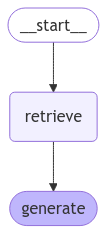

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Usage
Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

In [19]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5929}, page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='This benchmark evaluates the agent’s tool use capabilities at three levels:\n\nLevel-1 evaluates the ability to call the API. Given an API’s description, the model needs to determine whether to call a given API, call it correctly, and respond properly to API returns.\nLevel-2 examines the ability to retrieve the API. The model need

#### Stream steps:

In [22]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5929}, page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='This benchmark evaluates the agent’s tool use capabilities at three levels:\n\nLevel-1 evaluates the ability to call the API. Given an API’s description, the model needs to determine whether to call a given API, call it correctly, and respond properly to API returns.\nLevel-2 examines the ability to retrieve the API

#### Stream tokens:

In [21]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Task| Decom|position| is| not| explicitly| mentioned| in| the| provided| context|.| However|,| Level|-|3| of| the| benchmark| assess|es| the| ability| to| plan| API| beyond| retrieve| and| call|,| which| involves| breaking| down| complex| tasks| into| smaller| sub|-t|asks| that| require| multiple| API| calls|.| This| process| can| be| seen| as| a| form| of| task| decomposition|.||

### Customizing the prompt

In [23]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

### Query analysis

In [24]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

#### InMemoryVectorStore
We will need to update the documents in our vector store. We will use a simple InMemoryVectorStore for this, as we will use some of its specific features (i.e., metadata filtering). Refer to the vector store integration documentation for relevant features of your chosen vector store.

In [25]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [26]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

In [27]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

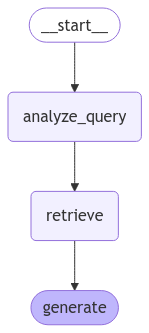

In [28]:
display(Image(graph.get_graph().draw_mermaid_png()))

We can test our implementation by specifically asking for context from the end of the post. Note that the model includes different information in its answer.

In [34]:
from langchain_ollama import ChatOllama, OllamaEmbeddings

# Define the new model name because llama3.2-vision doesn't support tools
new_model_name = "mistral-nemo:latest"

# Initialize the new model for ChatOllama
llm = ChatOllama(
    model=new_model_name,
    temperature=0,
    # num_predict=256,
    # other params ...
)

# Initialize the new model for OllamaEmbeddings
embeddings = OllamaEmbeddings(model=new_model_name)

In [33]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='ed3ff3b0-53a5-47a4-afd7-6e0f97be42ce', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39085, 'section': 'end'}, page_content='}\n]\nChallenges#\nAfter going through key ideas and demos of building LLM-centered agents, I start to see a couple common limitations:'), Document(id='4824f783-b10c-421a-83c1-564bdfdfaa53', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 42189, 'section': 'end'}, page_content='[13] Schick et al. “Toolformer: Language Models Can Teach Themselves to Use Tools.” arXiv preprint arXiv:2302.04761 (2023).\n[14] Weaviate Blog. Why is Vector Search so fast? Sep 13, 2022.\n[15] Li et al. “API-Bank: A Benchmark for Tool-Augmented LLMs” arXiv preprint arXiv:2304.08244 (2023).\n[16] Shen et al. “HuggingGPT: Solving AI Tasks with ChatGPT and its Friends 